In [ ]:
from google.colab import drive
drive.mount('/content/drive') #设置工作环境

Mounted at /content/drive


In [ ]:
import torch
torch.cuda.get_device_name() #查看GPU型号

'Tesla K80'

In [ ]:
import torchvision
# 工作环境，需更改
torch.manual_seed(101)
train_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/MNIST/',
                      train=True,
                      transform=torchvision.transforms.ToTensor(),
                      download=False)
test_dataset = torchvision.datasets.MNIST(root='/content/drive/MyDrive/MNIST/',
                      train=False,
                      transform=torchvision.transforms.ToTensor(),
                      download=False)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

class IBVAE(nn.Module):
    def __init__(self, z_dim=2):
        super(IBVAE, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=3, padding=1) # b, 32, 10, 10
        self.relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # b, 64, 10, 10
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # b, 64, 5, 5
        self.relu2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # b, 128, 5, 5
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=3, padding=1) # b, 256, 2, 2
        self.relu4 = nn.ReLU()
        self.line11 = nn.Linear(256*2*2, z_dim)
        self.line12 = nn.Linear(256*2*2, z_dim)
    
        self.line2 = nn.Linear(z_dim, 256*2*2)
        self.conv5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=3, padding=1) # b, 128, 4, 4
        self.relu5 = nn.ReLU()
        self.conv6 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=3, padding=1) # b, 32, 10, 10
        self.relu6 = nn.ReLU()
        self.conv7 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=3, padding=1) # b, 1, 28, 28
        self.sigm7 = nn.Sigmoid()

    def encode(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = x.view(-1, 256*2*2)
        return self.line11(x), self.line12(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.line2(z)
        z = z.view(-1, 256, 2, 2)
        z = self.conv5(z)
        z = self.relu5(z)
        z = self.conv6(z)
        z = self.relu6(z)
        z = self.conv7(z)
        return self.sigm7(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:
import numpy as np
from torch.autograd import Variable, grad

def torch_cov(X):
    D = X.shape[0]
    mean = torch.mean(X, dim=0).unsqueeze(-1)
    X = X.t() - mean
    return 1 / (D-1) * torch.mm(X, X.t())


def sigma_estimation(X, Y):
    # sigma from median distance
    D = distmat(torch.cat([X,Y]))
    D = D.detach().cpu().numpy()
    Itri = np.tril_indices(D.shape[0], -1)
    Tri = D[Itri]
    med = np.median(Tri)
    if med <= 0:
        med=np.mean(Tri)
    if med<1E-2:
        med=1E-2
    return med

def distmat(X):
    # distance matrix
    r = torch.sum(X*X, 1)
    r = r.view([-1, 1])
    a = torch.mm(X, torch.transpose(X,0,1))
    D = r.expand_as(a) - 2*a + torch.transpose(r,0,1).expand_as(a)
    D = torch.abs(D)
    return D

def kernelmat(X, sigma):
    # kernel matrix baker
    m = int(X.size()[0])
    dim = int(X.size()[1]) * 1.0
    H = torch.eye(m) - (1./m) * torch.ones([m,m])
    Dxx = distmat(X)
    if sigma:
        variance = 2.*sigma*sigma*X.size()[1]            
        Kx = torch.exp( -Dxx / variance).type(torch.FloatTensor)   # kernel matrices        
        # print(sigma, torch.mean(Kx), torch.max(Kx), torch.min(Kx))
    else:
        try:
            sx = sigma_estimation(X,X)
            Kx = torch.exp( -Dxx / (2.*sx*sx)).type(torch.FloatTensor)
        except RuntimeError as e:
            raise RuntimeError("Unstable sigma {} with maximum/minimum input ({},{})".format(
                sx, torch.max(X), torch.min(X)))
    Kxc = torch.mm(Kx,H)
    return Kxc

def HSIC_BI(X, encode, decode, hpara):
    # HSIC
    n = int(X.size()[0])
    X = X.view(n, -1)
    decode = decode.view(n, -1)
    Xxc = kernelmat(X, False)
    Zxc = kernelmat(encode, False)
    Yxc = kernelmat(decode, False)
    BI_value = 1.0/(n-1)**2 * torch.mm(Zxc, Xxc).trace() - hpara * 1.0/(n-1)**2 * torch.mm(Zxc, Yxc).trace()
    return BI_value

def IB_loss_function(decode, X, mu, logvar, bpara, hpara):
    BCE = F.binary_cross_entropy(decode.view(-1, 784), X.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    IB_loss = HSIC_BI(X, mu, decode, hpara)
    return BCE + KLD + bpara * IB_loss


In [ ]:
import time
from tqdm import tqdm

# parameters
latent_dim = 2
num_epochs = 3
bpara = 1e4
hpara = 500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = IBVAE(z_dim=latent_dim).to(device)
model = torch.load('IBVAE_MNIST_pretrain.pth').to(device) # 加载模型
optimizer = optim.Adam(model.parameters(), lr=1e-10)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# recode
epochs = []
train_losses = []
test_losses = []
times = []

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        decode, mu, logvar = model(data)
        loss = IB_loss_function(decode, data, mu.cpu(), logvar.cpu(), bpara, hpara)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    end = time.time()
    scheduler.step()
    train_losses.append(train_loss/len(train_loader.dataset))
    times.append(end-start)
    epochs.append(epoch)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(tqdm(test_loader)):
            data = data.to(device)
            decode, mu, logvar = model(data)
            test_loss += IB_loss_function(decode, data, mu.cpu(), logvar.cpu(), bpara, hpara).item()
        test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('epoch %d, training loss %.6f, test loss %.6f, time %.1f sec'
      %(epoch + 1, train_loss / len(train_loader.dataset), test_loss, end - start))


  0%|          | 4/938 [00:00<00:28, 33.08it/s]

epoch 1, training loss 119.705794, test loss 116.251990, time 29.5 sec


  0%|          | 4/938 [00:00<00:28, 33.33it/s]

epoch 2, training loss 119.725081, test loss 116.366897, time 29.2 sec


100%|██████████| 157/157 [00:02<00:00, 60.57it/s]

epoch 3, training loss 119.647082, test loss 116.323550, time 29.2 sec


In [ ]:
# torch.save(model, 'IBVAE_MNIST_pretrain.pth') # 保存模型

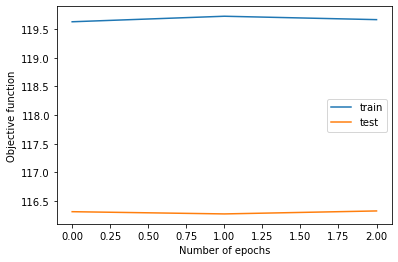

In [ ]:
from matplotlib import pyplot as plt
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, test_losses, label="test")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Objective function")
plt.show()

In [ ]:
# model = torch.load('IBVAE_MNIST_pretrain.pth').to(device) # 加载模型

In [ ]:
model.eval()
with torch.no_grad():
    for i, (data, y_temp) in enumerate(tqdm(test_loader)):
        if (i == 0):
            testx = data
            testy = y_temp
            data = data.to(device)
            decode_temp, mu_temp, logvar_temp = model(data)
            test_mu = mu_temp.cpu()
            test_logvar = logvar_temp.cpu()
            test_decode = decode_temp.cpu()
        else:
            testx = torch.cat((testx, data), 0)
            testy = torch.cat((testy, y_temp), 0)
            data = data.to(device)
            decode_temp, mu_temp, logvar_temp = model(data)
            test_mu = torch.cat((test_mu, mu_temp.cpu()), 0)
            test_logvar = torch.cat((test_logvar, logvar_temp.cpu()), 0)
            test_decode = torch.cat((test_decode, decode_temp.cpu()), 0)


100%|██████████| 157/157 [00:03<00:00, 42.87it/s]


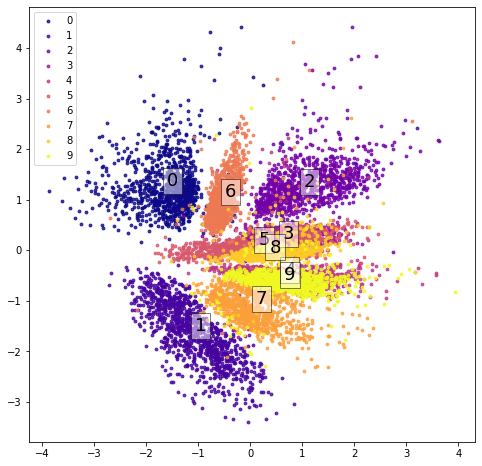

In [ ]:
from matplotlib import pyplot as plt

cmap = plt.get_cmap('plasma',10)
v_x = test_mu.numpy()
v_y = testy.numpy()
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
classes = [0,1,2,3,4,5,6,7,8,9]
for key in classes:
    ix = np.where(v_y==key)
    ax.scatter(v_x[ix][:,0], v_x[ix][:,1], color=cmap(key), label=key, s=8, alpha=0.8)
    ax.text(np.mean(v_x[ix][:,0]), np.mean(v_x[ix][:,1]), key, fontsize=18, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()
plt.savefig("IBVAE_result.png")
plt.show()

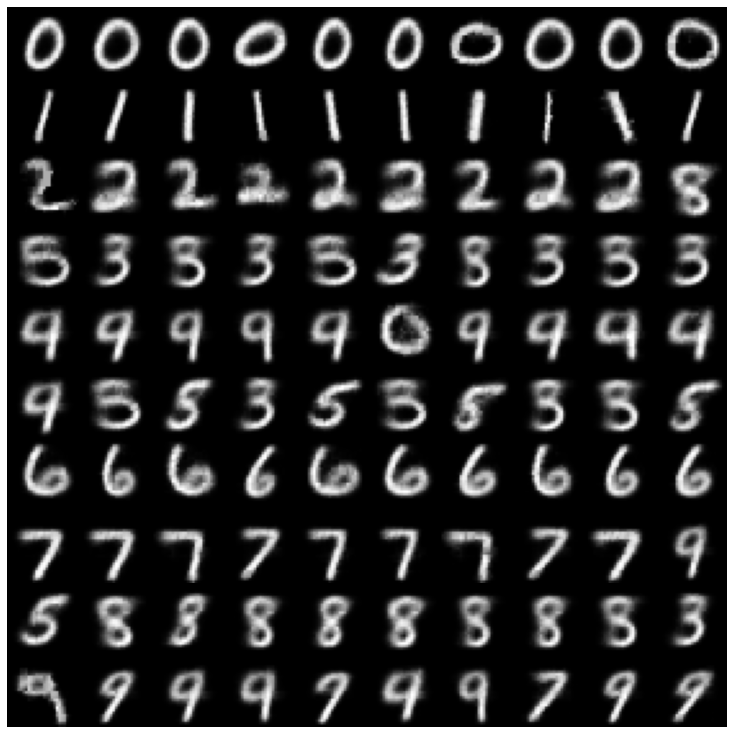

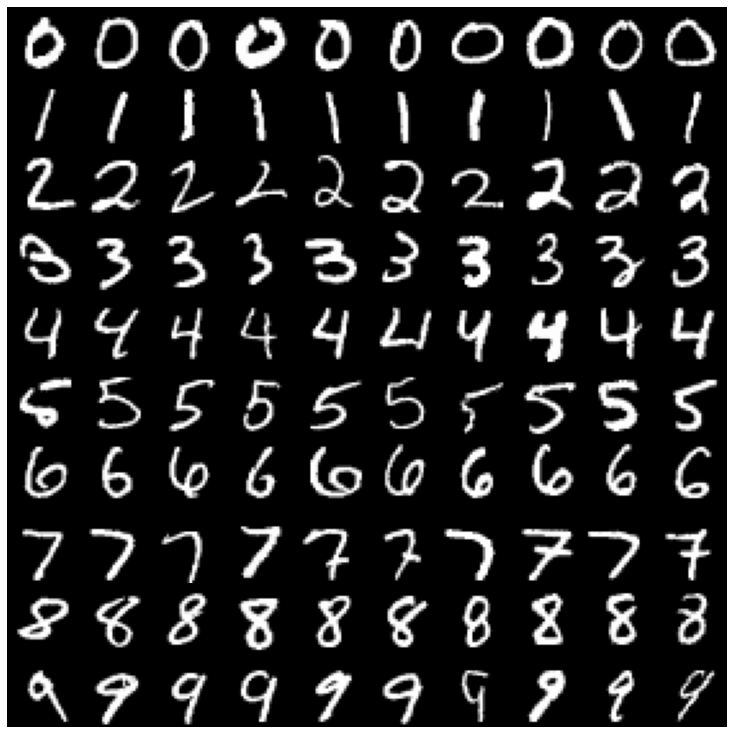

In [ ]:
show_img = True
if show_img:
    idx = []
    for key in classes:
        ix = np.where(v_y==key)[0][0:10]
        idx.extend(ix)
        X0 = testx[idx,:,:,:]
        recon_X0 = test_decode[idx,:,:,:]
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax[i,j].imshow(recon_X0[i*10+j][0], cmap="gray")
            ax[i,j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    # plt.savefig("IBVAE_MNIST.png")
    plt.show()
    
    fig0, ax0 = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            ax0[i,j].imshow(X0[i*10+j][0], cmap="gray")
            ax0[i,j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    # plt.savefig("MNIST.png")
    plt.show()


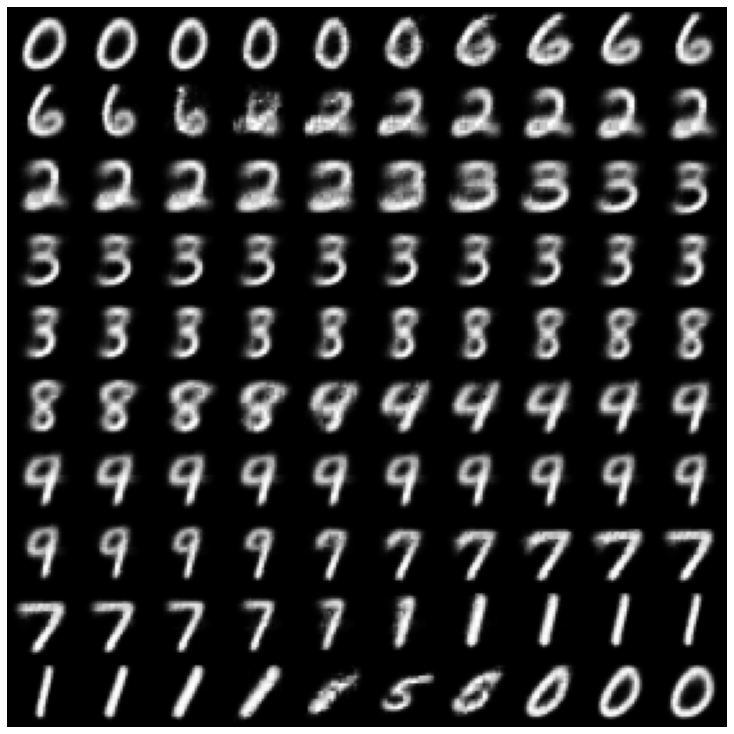

In [ ]:
zvalue = np.zeros((10, 2))
for key in classes:
    ix = np.where(v_y==key)
    zvalue[key, 0] = np.median(v_x[ix][:,0])
    zvalue[key, 1] = np.median(v_x[ix][:,1])

def genzvalue(zvalue, num1, num2, num=10):
    return np.linspace(zvalue[num1,:], zvalue[num2,:], num, endpoint = True)

gen_zvalues06 = model.decode(torch.from_numpy(genzvalue(zvalue, 0, 6, 10).astype(np.float32)).to(device))
gen_zvalues62 = model.decode(torch.from_numpy(genzvalue(zvalue, 6, 2, 10).astype(np.float32)).to(device))
gen_zvalues23 = model.decode(torch.from_numpy(genzvalue(zvalue, 2, 3, 10).astype(np.float32)).to(device))
gen_zvalues35 = model.decode(torch.from_numpy(genzvalue(zvalue, 3, 5, 10).astype(np.float32)).to(device))
gen_zvalues58 = model.decode(torch.from_numpy(genzvalue(zvalue, 5, 8, 10).astype(np.float32)).to(device))
gen_zvalues84 = model.decode(torch.from_numpy(genzvalue(zvalue, 8, 4, 10).astype(np.float32)).to(device))
gen_zvalues49 = model.decode(torch.from_numpy(genzvalue(zvalue, 4, 9, 10).astype(np.float32)).to(device))
gen_zvalues97 = model.decode(torch.from_numpy(genzvalue(zvalue, 9, 7, 10).astype(np.float32)).to(device))
gen_zvalues71 = model.decode(torch.from_numpy(genzvalue(zvalue, 7, 1, 10).astype(np.float32)).to(device))
gen_zvalues10 = model.decode(torch.from_numpy(genzvalue(zvalue, 1, 0, 10).astype(np.float32)).to(device))

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    ax[0,i].imshow(gen_zvalues06[i][0].cpu().detach().numpy(), cmap="gray")
    ax[1,i].imshow(gen_zvalues62[i][0].cpu().detach().numpy(), cmap="gray")
    ax[2,i].imshow(gen_zvalues23[i][0].cpu().detach().numpy(), cmap="gray")
    ax[3,i].imshow(gen_zvalues35[i][0].cpu().detach().numpy(), cmap="gray")
    ax[4,i].imshow(gen_zvalues58[i][0].cpu().detach().numpy(), cmap="gray")
    ax[5,i].imshow(gen_zvalues84[i][0].cpu().detach().numpy(), cmap="gray")
    ax[6,i].imshow(gen_zvalues49[i][0].cpu().detach().numpy(), cmap="gray")
    ax[7,i].imshow(gen_zvalues97[i][0].cpu().detach().numpy(), cmap="gray")
    ax[8,i].imshow(gen_zvalues71[i][0].cpu().detach().numpy(), cmap="gray")
    ax[9,i].imshow(gen_zvalues10[i][0].cpu().detach().numpy(), cmap="gray")
    for j in range(10):
        ax[j, i].axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
# plt.savefig("IBVAE_MNIST_linspace.png")
plt.show()

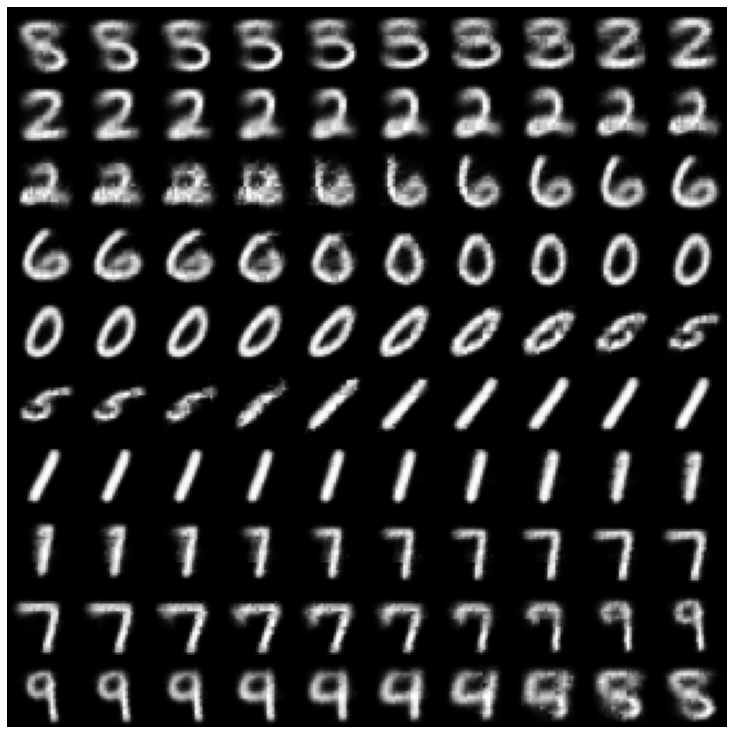

In [ ]:
# 对隐变量在圆上取值
gen_zvalues0 = model.decode(torch.from_numpy(1.6*np.cos(np.linspace(np.array([0,-0.5*np.pi]), np.array([2*np.pi,1.5*np.pi]), 100, endpoint = True)).astype(np.float32)).to(device))

fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(gen_zvalues0[i*10+j][0].cpu().detach().numpy(), cmap="gray")
        ax[i, j].axis('off')

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()